<a href="https://colab.research.google.com/github/Txlu-OG/Learn/blob/main/Assignment_10_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

   rating       date         variation  \
0       5  31-Jul-18  Charcoal Fabric    
1       5  31-Jul-18  Charcoal Fabric    
2       4  31-Jul-18    Walnut Finish    
3       5  31-Jul-18  Charcoal Fabric    
4       5  31-Jul-18  Charcoal Fabric    

                                    verified_reviews  feedback  
0                                      Love my Echo!         1  
1                                          Loved it!         1  
2  Sometimes while playing a game, you can answer...         1  
3  I have had a lot of fun with this thing. My 4 ...         1  
4                                              Music         1  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   rating            3150 non-null   int64 
 1   date              3150 non-null   object
 2   variation         3150 non-null   object
 3   verified_reviews

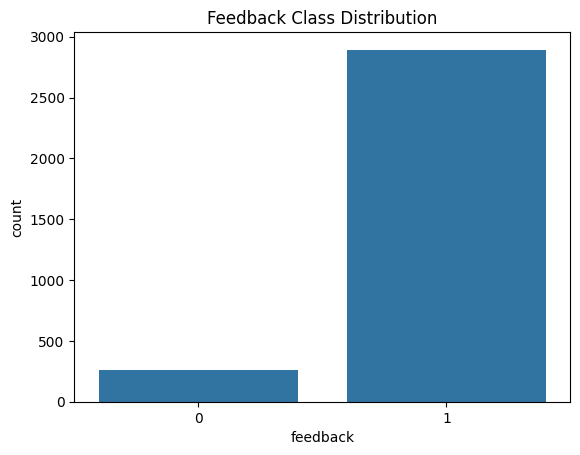

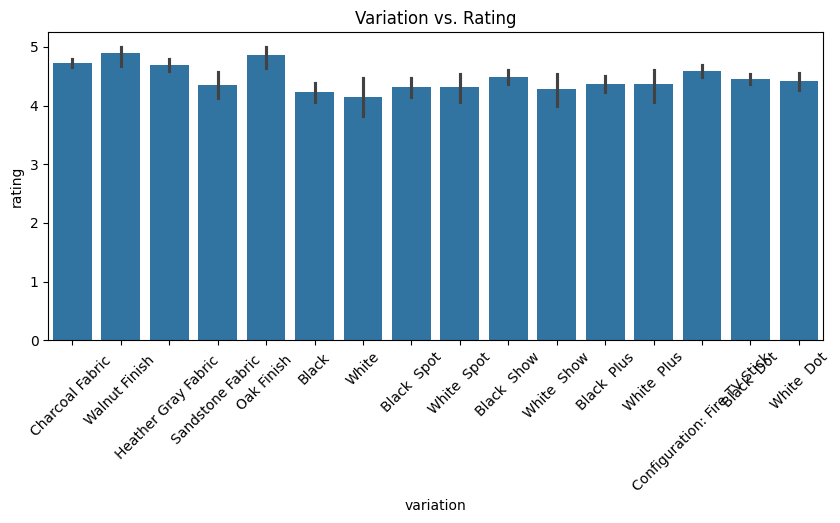

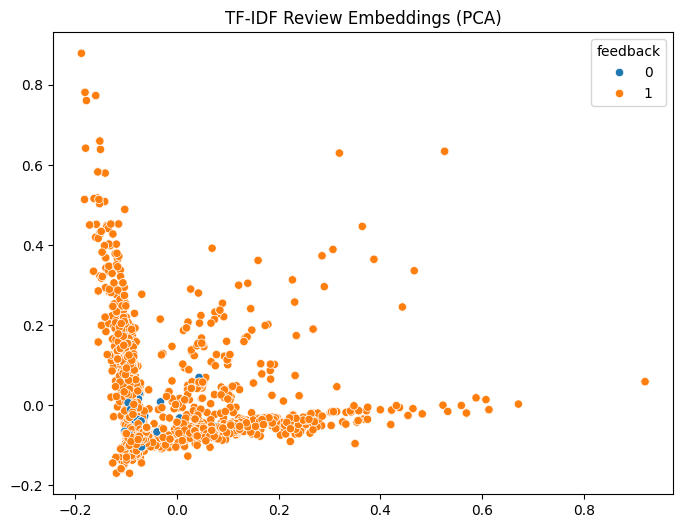

Logistic Regression
               precision    recall  f1-score   support

           0       0.96      0.40      0.56        58
           1       0.94      1.00      0.97       572

    accuracy                           0.94       630
   macro avg       0.95      0.70      0.77       630
weighted avg       0.94      0.94      0.93       630

ROC-AUC: 0.6974017361948397
Random Forest
               precision    recall  f1-score   support

           0       1.00      0.36      0.53        58
           1       0.94      1.00      0.97       572

    accuracy                           0.94       630
   macro avg       0.97      0.68      0.75       630
weighted avg       0.94      0.94      0.93       630

ROC-AUC: 0.6810344827586207


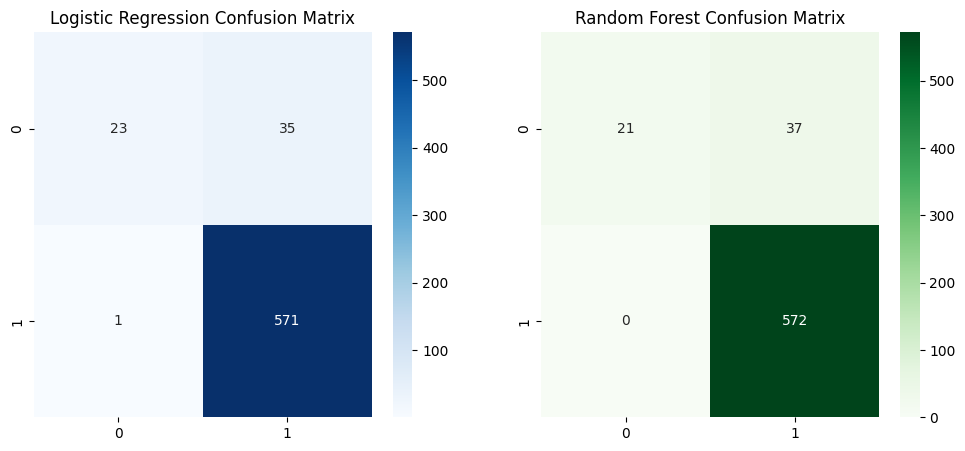

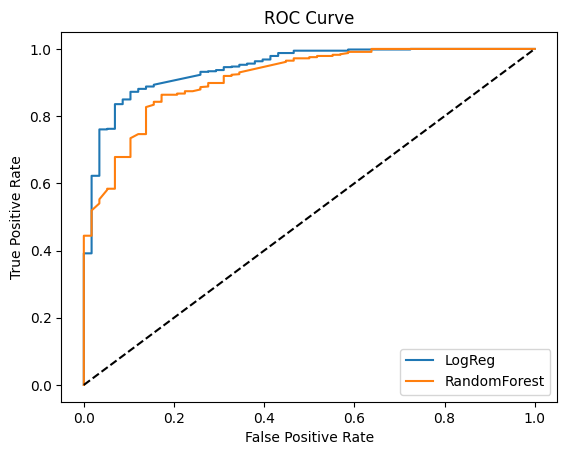

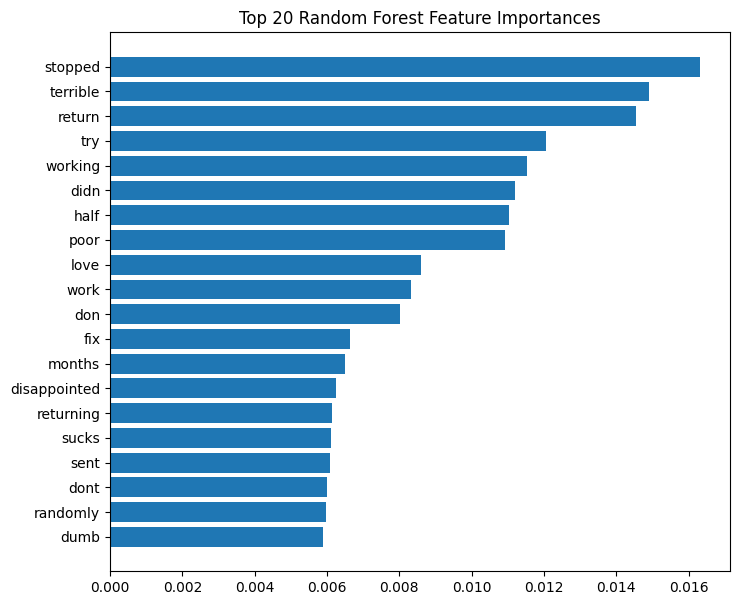

Sample prediction: 1


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: adedamolaogundipe11 (adedamolaogundipe11-willis-college-your-career-is-waiting-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
100,0.270500
200,0.187400
300,0.173400


BERT PyTorch Eval Results: {'eval_loss': 0.19700761139392853, 'eval_runtime': 275.7228, 'eval_samples_per_second': 2.285, 'eval_steps_per_second': 0.287, 'epoch': 1.0}


In [7]:
# 1. IMPORT LIBRARIES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.decomposition import PCA

# For BERT with PyTorch
!pip install torch torchvision torchaudio --quiet
!pip install transformers --quiet
!pip install --upgrade transformers --quiet
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments

# 2. LOAD DATA
import csv

df = pd.read_csv(
    "/content/drive/My Drive/amazon_alexa.tsv",
    sep="\t",
    engine="python",
    encoding="utf-8",
    quoting=csv.QUOTE_MINIMAL,
    on_bad_lines="warn"
)
print(df.head())
print(df.info())
print(df.describe())

# 3. EDA AND PREPROCESSING
sns.countplot(x='feedback', data=df)
plt.title('Feedback Class Distribution')
plt.show()

if 'variation' in df.columns and 'rating' in df.columns:
    plt.figure(figsize=(10,4))
    sns.barplot(x='variation', y='rating', data=df)
    plt.title('Variation vs. Rating')
    plt.xticks(rotation=45)
    plt.show()

for col in ['date', 'rating']:
    if col in df.columns:
        df = df.drop(col, axis=1)

if 'variation' in df.columns:
    df = pd.get_dummies(df, columns=['variation'])

df['verified_reviews'] = df['verified_reviews'].fillna('')
df['feedback'] = df['feedback'].fillna(df['feedback'].mode()[0])

# 4. FEATURE ENGINEERING: TF-IDF
bow_vectorizer = CountVectorizer(max_features=2000, stop_words='english')
X_bow = bow_vectorizer.fit_transform(df['verified_reviews'])
tfidf_vectorizer = TfidfVectorizer(max_features=2000, stop_words='english')
X_tfidf = tfidf_vectorizer.fit_transform(df['verified_reviews'])

# Visualize TF-IDF embeddings
pca = PCA(n_components=2)
X_tfidf_pca = pca.fit_transform(X_tfidf.toarray())
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_tfidf_pca[:,0], y=X_tfidf_pca[:,1], hue=df['feedback'])
plt.title('TF-IDF Review Embeddings (PCA)')
plt.show()

# 5. TRAIN-TEST SPLIT
X_other = df.drop(['verified_reviews','feedback'], axis=1) if 'variation' in df.columns else None
X = np.concatenate([X_tfidf.toarray(), X_other.values], axis=1) if X_other is not None else X_tfidf.toarray()
y = df['feedback']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 6. TRADITIONAL ML: LOGISTIC REGRESSION AND RANDOM FOREST
logreg = LogisticRegression(max_iter=2000)
logreg_cv = GridSearchCV(logreg, {'C':[0.1,1,10]}, cv=3)
logreg_cv.fit(X_train, y_train)
logreg_best = logreg_cv.best_estimator_

rf = RandomForestClassifier(random_state=42)
rf_cv = GridSearchCV(rf, {'n_estimators':[100,200], 'max_depth':[None,10,20]}, cv=3)
rf_cv.fit(X_train, y_train)
rf_best = rf_cv.best_estimator_

# 7. EVALUATION
y_pred_lr = logreg_best.predict(X_test)
print("Logistic Regression\n", classification_report(y_test, y_pred_lr))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_lr))

y_pred_rf = rf_best.predict(X_test)
print("Random Forest\n", classification_report(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_rf))

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.heatmap(confusion_matrix(y_test, y_pred_lr), annot=True, fmt='d', cmap='Blues')
plt.title('Logistic Regression Confusion Matrix')
plt.subplot(1,2,2)
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Greens')
plt.title('Random Forest Confusion Matrix')
plt.show()

for model, label in zip([logreg_best, rf_best], ['LogReg', 'RandomForest']):
    probs = model.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, probs)
    plt.plot(fpr, tpr, label=label)
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

importances = rf_best.feature_importances_
indices = np.argsort(importances)[-20:]
feature_names = np.array(
    list(tfidf_vectorizer.get_feature_names_out()) +
    (list(X_other.columns) if X_other is not None else [])
)
plt.figure(figsize=(8,7))
plt.barh(feature_names[indices], importances[indices])
plt.title('Top 20 Random Forest Feature Importances')
plt.show()

# 8. SAMPLE PREDICTION FUNCTION
def predict_sentiment(text):
    text_feat = tfidf_vectorizer.transform([text])
    if X_other is not None:
        other_feat = np.zeros((1, X_other.shape[1]))
        final_input = np.concatenate([text_feat.toarray(), other_feat], axis=1)
    else:
        final_input = text_feat.toarray()
    sentiment = rf_best.predict(final_input)[0]
    return sentiment

sample = "I love my Alexa device! It's so helpful."
print("Sample prediction:", predict_sentiment(sample))

# 9. PYTORCH BERT CLASSIFIER

# Prepare text and labels
texts = df['verified_reviews'].astype(str).tolist()
labels = df['feedback'].astype(int).tolist()
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(
    texts, labels, test_size=0.2, random_state=42)

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Define custom dataset
from torch.utils.data import Dataset

class ReviewDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=max_len)
        self.labels = labels
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.labels)

train_ds = ReviewDataset(X_train_b, y_train_b, tokenizer)
test_ds = ReviewDataset(X_test_b, y_test_b, tokenizer)

# Training arguments
training_args = TrainingArguments(
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=1,
    eval_steps=100,
    output_dir='./results',
    logging_dir='./logs',
    logging_steps=100,
    save_strategy="no"
)

# Setup model and trainer
bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

trainer = Trainer(
    model=bert_model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
)

trainer.train()
eval_results = trainer.evaluate()
print("BERT PyTorch Eval Results:", eval_results)
